In [1]:
from PIL import Image
import os, glob, cv2, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import applications, optimizers, losses, layers
from tensorflow.keras.layers import Input, concatenate, Dense, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ramdom_seed = 4885
tf.random.set_random_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)

In [3]:
def SSIM_cs(y_true, y_pred):
    patches_true = tf.extract_image_patches(y_true, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")
    patches_pred = tf.extract_image_patches(y_pred, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")

    var_true = K.var(patches_true, axis=3)
    var_pred = K.var(patches_pred, axis=3)
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)
    c2 = 0.03 ** 2
    ssim = (2 * std_pred * std_true + c2)
    denom = (var_pred + var_true + c2)
    ssim /= denom
    ssim = tf.where(tf.is_nan(ssim), K.zeros_like(ssim), ssim)
    return 1 - K.mean(ssim)

def augment_image_colorspace(image):
    # input shape [h, w * seq , c]
    random_gamma = random.uniform(0.8,1.2)
    random_brightness = random.uniform(0.5, 2.0)
    random_colors = [random.uniform(0.8,1.2), random.uniform(0.8,1.2), random.uniform(0.8,1.2)]
    # Randomly shift gamma.
    image_aug = image**random_gamma
    # Randomly shift brightness. 
    image_aug *= random_brightness
    # Randomly shift color. 
    white = np.ones([image.shape[0], image.shape[1]])
    color_image = np.stack([white * random_colors[i] for i in range(3)], axis=2)
    image_aug *= color_image
    # Saturate.
    image_aug = np.clip(image_aug, 0, 1)
    return image_aug

def data_generator(model_depth, data_path, batch, aug):
    dir_list = os.listdir(data_path)
    img_list = []
    for j in dir_list:
        img_path = os.path.join(data_path, j)
        tmp_list = sorted(glob.glob(img_path +'/*.png'))
        img_list += tmp_list
    idx = 0
    while 1:
        idx_list = list(range(0,len(img_list)))
        random.shuffle(idx_list)
        bat_img = []
        bat_lab = []
        if idx > len(idx_list) - batch:
            idx = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx+batch]
            idx = idx + batch
            
        for i in tmp_list:
            img_tmp = cv2.imread(img_list[i])
            
            if img_tmp is None:
                print(img_list[i])
            if aug == 1:    
                img = augment_image_colorspace(cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.)
            else:
                img = cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.
            lab = cv2.cvtColor(img_tmp[:,256:,:], cv2.COLOR_BGR2GRAY)/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), np.abs(model_depth.predict(np.array(bat_img))[0] - np.array(bat_lab)[..., np.newaxis])
#         np.greater(np.abs(model_depth.predict(np.array(bat_img))[0] - np.array(bat_lab)[..., np.newaxis]), 0.3).astype(np.int)

In [4]:
def depth(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2), activation = 'relu')(inputs)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv1)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv2)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv3)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv3_1)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1), activation = 'relu')(conv4)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv4_1)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv5)
    
    deconv5 = Conv2D(512, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5_1))
    deconv4 = Conv2D(256, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(deconv5))
    merge4 = concatenate([deconv4,conv3], axis = 3)    
    aux3 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge4)
    deconv3 = Conv2D(128, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge4))
    merge3 = concatenate([deconv3,conv2], axis = 3)
    aux2 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge3)
    deconv2 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge3))
    merge2 = concatenate([deconv2,conv1], axis = 3)
    aux1 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge2)
    deconv1 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge2))
    output = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(deconv1)
    
    model = Model(inputs = inputs, outputs = [output, aux1, aux2, aux3])
    return model

def mask(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2), activation = 'relu')(inputs)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv1)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv2)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv3)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv3_1)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1), activation = 'relu')(conv4)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv4_1)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv5)
    
    deconv5 = Conv2D(512, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5_1))
    deconv4 = Conv2D(256, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(deconv5))
    merge4 = concatenate([deconv4,conv3], axis = 3)    
    deconv3 = Conv2D(128, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge4))
    merge3 = concatenate([deconv3,conv2], axis = 3)
    deconv2 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge3))
    merge2 = concatenate([deconv2,conv1], axis = 3)
    deconv1 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge2))
    output = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(deconv1)
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [5]:
gen_input = Input(shape=(256,256,3))
model_depth = depth(gen_input)
model_depth.compile(optimizer = Adam(lr = 0.0002), loss = [SSIM_cs,SSIM_cs,SSIM_cs,SSIM_cs], loss_weights = [0.64, 0.16, 0.04, 0.01])

gen_input = Input(shape=(256,256,3))
model_mask = mask(gen_input)
model_mask.compile(optimizer = Adam(lr = 0.0002), loss = 'mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
model_mask.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 128)  204928      conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 256)  819456      conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 

In [7]:
model_depth.load_weights('checkpoints_allcv/test_cv_cv_aux_16_0.00014.h5')

In [8]:
train_path = '/data1/depth/endo_sim3/train/'
batch = 32
train = data_generator(model_depth, train_path, batch, 1)
val_path = '/data1/depth/endo_sim3/val/'
batch = 32
val = data_generator(model_depth, val_path, batch, 0)

In [9]:
dir_list = os.listdir(train_path)
train_img_list = []
for j in dir_list:
    img_path = os.path.join(train_path, j)
    tmp_list = sorted(glob.glob(img_path +'/*.png'))
    train_img_list += tmp_list
    
print(len(train_img_list))

20312


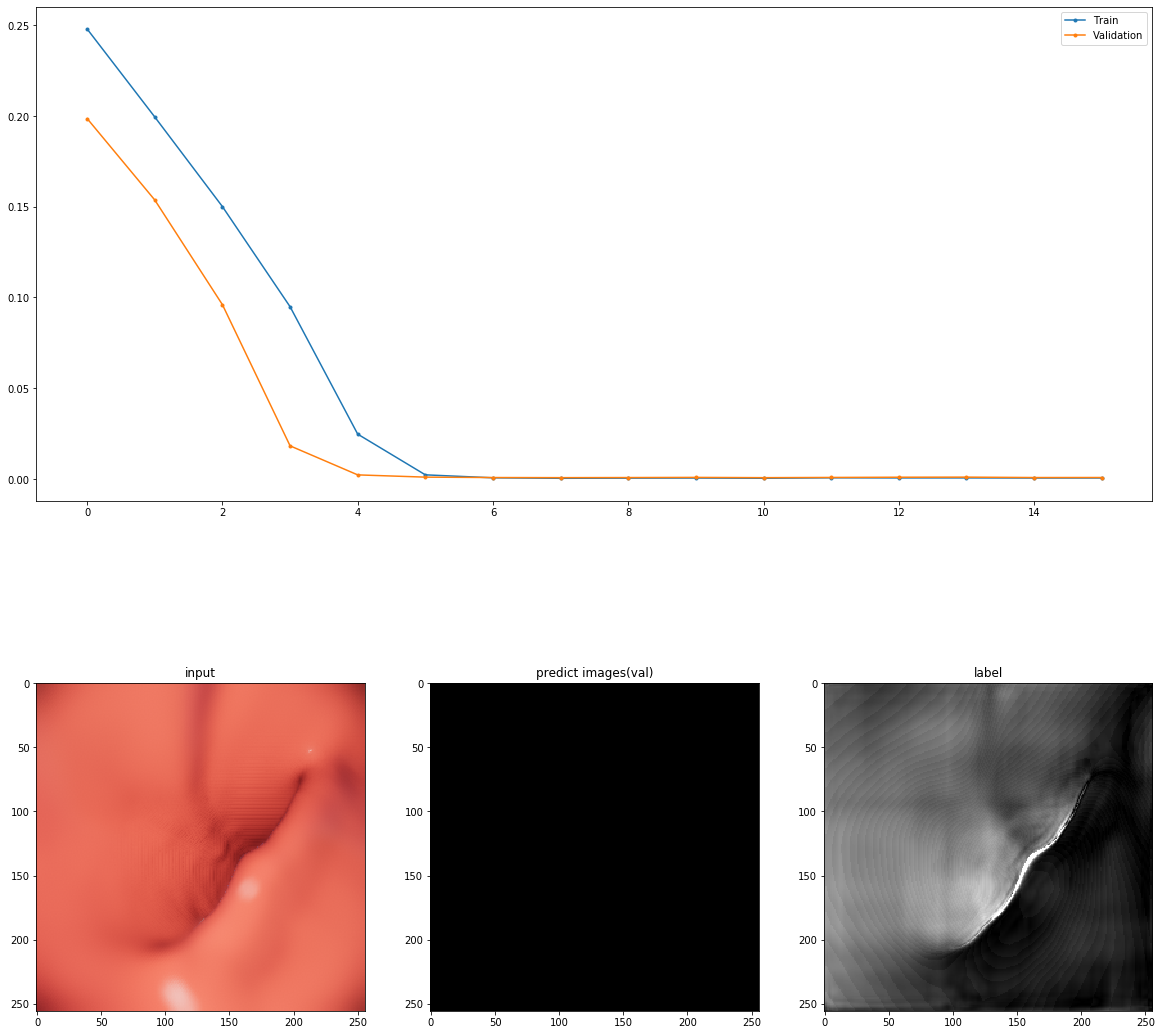

In [10]:
model_name = 'mask'
scale = 10
steps = int(np.ceil(len(train_img_list)/batch))
steps = 1
epochs = 16

total_loss = []
val_total_loss = []

for epoch in range(epochs):
    for step in range(steps):
        train_img, train_lab = next(train)
        loss = model_mask.train_on_batch(train_img, train_lab)
    total_loss.append(loss)
    val_img, val_lab = next(val)
    val_loss = model_mask.evaluate(val_img, val_lab)
    
    val_total_loss.append(val_loss)
    plt.cla()
    plt.clf()
    plt.close()
    clear_output(wait=True)
    val_p = model_mask.predict(val_img)
    
    
    plt.figure(figsize=(20, 20))
    plt.subplot(211)
    plt.plot(total_loss,'.-')
    plt.plot(val_total_loss,'.-')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(234)
    plt.imshow(val_img[0])
    plt.title("input")
    plt.subplot(235)
    plt.imshow(np.reshape(val_p[0]*scale, (256,256)), cmap = 'gray', vmin = 0, vmax = 1)
    plt.title("predict images(val)")
    plt.subplot(236)
    plt.imshow(np.reshape(val_lab[0]*scale, (256,256)), cmap = 'gray', vmin = 0, vmax = 1)
    plt.title("label")
    plt.show()
    if epoch % 5 == 0:
        model_path = "checkpoints_error/test_%s_%02d_%.5f.h5"%(model_name, epoch+1, loss)
        model_mask.save_weights(model_path)

In [11]:
data_path = '/data1/depth/endo_sim2/train'

In [12]:
dir_list = os.listdir(data_path)
img_list = []
for j in dir_list:
    img_path = os.path.join(data_path, j)
    tmp_list = sorted(glob.glob(img_path +'/*.png'))
    img_list += tmp_list

In [13]:
img = cv2.cvtColor(cv2.imread(img_list[0]),cv2.COLOR_BGR2RGB)
predic = model.predict(img[np.newaxis,:,:256,:]/255.)

NameError: name 'model' is not defined

In [ ]:
predic[0][0].shape

In [ ]:
lab = cv2.cvtColor(img[:,256:,:], cv2.COLOR_BGR2GRAY)/255.

In [ ]:
lab.shape

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(np.reshape(predic[0][0],(256,256)), cmap ='gray', vmin = 0, vmax = 1)
plt.subplot(1,3,2)
plt.imshow(img[:,256:,:])
plt.subplot(1,3,3)
plt.imshow(np.abs(np.reshape(predic[0][0],(256,256)) - cv2.cvtColor(img[:,256:,:], cv2.COLOR_BGR2GRAY)/255.), cmap ='gray')